In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from zpdes import ZPDES

In [2]:
def masked_min(elos, mask):
    # Computes a minimum over the list of provided elos
    assert elos.shape == mask.shape, "Input Tensors shape do not match"
    
    return min(elos[(elos * mask) > 0])

In [3]:
def elo_proba(elo_a, elo_b):
    # Compute the probability of a winning over b, or student a succeeding at an exercise b
    return torch.sigmoid(
        np.log(10) * (elo_a - elo_b) / 400
    )

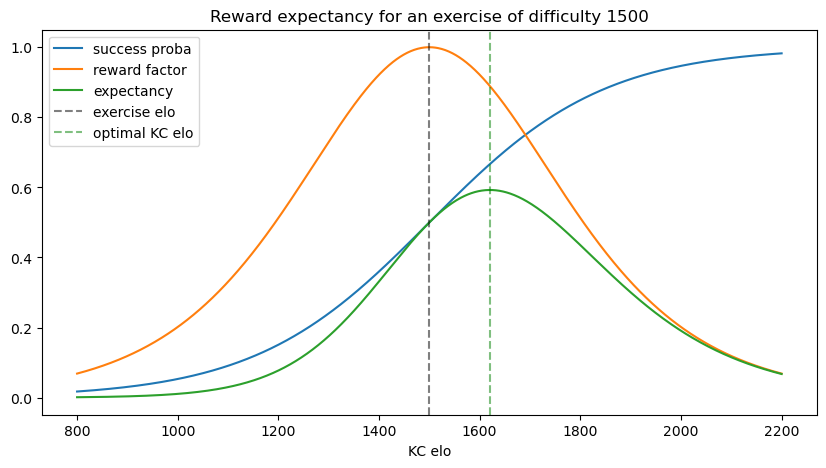

In [4]:
x = np.linspace(800, 2200, 1000)
y = [elo_proba(torch.tensor(xi), torch.tensor(1500)) for xi in x]
y2 = [4 * yi * (1 - yi) for yi in y]
y3 = [y[i] * y2[i] for i in range (len(x))]

plt.figure(figsize=(10,5))
plt.plot(x, y, label="success proba")
plt.plot(x, y2, label="reward factor")
plt.plot(x, y3, label="expectancy")
plt.axvline(1500, color="k", linestyle="--", label="exercise elo", alpha=.5)
plt.axvline(x[np.argmax(y3)], color="g", linestyle="--", label="optimal KC elo", alpha=0.5)
plt.xlabel("KC elo")
plt.title("Reward expectancy for an exercise of difficulty 1500")
plt.legend();

In [9]:
class PatientModel():
    def __init__(self):
        # Initialize all parameters
        self.init_parameters()

    def init_parameters(self):
        # EXS
        self.exercise_names = ['FEPB', 'FEBB', 'FLFS', 'FLFU', 'FR', 'QR', 'QFU', 'QLM', 'QTR', 'QFUR']
        self.exercises = [[e + '1', e + '2', e + '3'] for e in self.exercise_names]
        self.exercises = sum(self.exercises, [])
        self.exercise_names.append('QB')
        self.exercises.append('QB')
        self.exercises = { self.exercises[i] : i for i in range(len(self.exercises) ) }
        self.n_ex = len(self.exercises)

        # KCS
        kcs = ['FE', 'FR', 'FLF', 'QE', 'QR', 'QF', 'QLF']
        self.kcs = { kcs[i] : i for i in range(len(kcs) ) }
        self.inv_kcs = {v: k for k, v in self.kcs.items()}
        self.n_kc = len(self.kcs)

        # KC graph
        self.kc_graph = torch.zeros(len(self.kcs), len(self.kcs))
        self.kc_graph[self.kcs['FR'], self.kcs['QR']] = 1
        self.kc_graph[self.kcs['FE'], self.kcs['QE']] = 1
        self.kc_graph[self.kcs['FLF'], self.kcs['QLF']] = 1

        
        # EX graph
        self.ex_graph = torch.zeros(len(self.exercises), len(self.kcs))
        for i in range(1, 4):
            self.ex_graph[self.exercises['FEPB' + str(i)], self.kcs['FE']] = 1
            self.ex_graph[self.exercises['FEBB' + str(i)], self.kcs['FE']] = 1
            self.ex_graph[self.exercises['FLFS' + str(i)], self.kcs['FLF']] = 1
            self.ex_graph[self.exercises['FLFU' + str(i)], self.kcs['FLF']] = 1
            self.ex_graph[self.exercises['FR' + str(i)], self.kcs['FR']] = 1
            self.ex_graph[self.exercises['QR' + str(i)], self.kcs['QE']] = 1
            self.ex_graph[self.exercises['QR' + str(i)], self.kcs['QR']] = 1
            self.ex_graph[self.exercises['QR' + str(i)], self.kcs['QF']] = 1
            self.ex_graph[self.exercises['QR' + str(i)], self.kcs['QLF']] = 1
            self.ex_graph[self.exercises['QFU' + str(i)], self.kcs['QE']] = 1
            self.ex_graph[self.exercises['QFU' + str(i)], self.kcs['QF']] = 1
            self.ex_graph[self.exercises['QFUR' + str(i)], self.kcs['QE']] = 1
            self.ex_graph[self.exercises['QFUR' + str(i)], self.kcs['QF']] = 1
            self.ex_graph[self.exercises['QTR' + str(i)], self.kcs['QR']] = 1
            self.ex_graph[self.exercises['QLM' + str(i)], self.kcs['QLF']] = 1

        
        self.ex_graph[self.exercises['QB'], self.kcs['QE']] = 1
        self.ex_graph[self.exercises['QB'], self.kcs['QR']] = 1
        self.ex_graph[self.exercises['QB'], self.kcs['QF']] = 1
        self.ex_graph[self.exercises['QB'], self.kcs['QLF']] = 1

        
        # EX elo
        self.ex_elo = torch.zeros(self.n_ex)
        self.ex_elo[self.exercises['FEPB1']] = 1000
        self.ex_elo[self.exercises['FEBB1']] = 1000
        self.ex_elo[self.exercises['FLFS1']] = 1000
        self.ex_elo[self.exercises['FLFU1']] = 1000
        self.ex_elo[self.exercises['FR1']] = 1000
        self.ex_elo[self.exercises['QB']] = 1000
        self.ex_elo[self.exercises['QR1']] = 1200
        self.ex_elo[self.exercises['QFU1']] = 1400
        self.ex_elo[self.exercises['QLM1']] = 1600
        self.ex_elo[self.exercises['QTR1']] = 1600
        self.ex_elo[self.exercises['QFUR1']] = 2000
        for ex in self.exercise_names:
            if ex == 'QB': continue
            elif ex[0] == 'F':
                self.ex_elo[self.exercises[ex + '2']] = self.ex_elo[self.exercises[ex+'1']] + 400
                self.ex_elo[self.exercises[ex + '3']] = self.ex_elo[self.exercises[ex+'2']] + 400
            else:
                self.ex_elo[self.exercises[ex + '2']] = self.ex_elo[self.exercises[ex+'1']] + 200
                self.ex_elo[self.exercises[ex + '3']] = self.ex_elo[self.exercises[ex+'2']] + 200
            
        self.log_success_reward = torch.Tensor([3.3])
        self.log_failure_reward = torch.Tensor([1.])

    def init_patient(self, profile):
        self.initial_kc_elo = torch.zeros(self.n_kc)
        if profile == "mobility":
            flexibility_base_elo = 800. + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FE']] = flexibility_base_elo + 100. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FLF']] = flexibility_base_elo + 100. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FR']] = flexibility_base_elo + 100. * torch.randn(1)

            quality_base_elo = 1500. + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QR']] = quality_base_elo + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QF']] = quality_base_elo + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QLF']] = quality_base_elo + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QE']] = quality_base_elo + 50. * torch.randn(1)

        elif profile == "stability":
            flexibility_base_elo = 1500. + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FE']] = flexibility_base_elo + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FLF']] = flexibility_base_elo + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['FR']] = flexibility_base_elo + 50. * torch.randn(1)

            quality_base_elo = 800. + 50. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QR']] = quality_base_elo + 100. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QF']] = quality_base_elo + 100. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QLF']] = quality_base_elo + 100. * torch.randn(1)
            self.initial_kc_elo[self.kcs['QE']] = quality_base_elo + 100. * torch.randn(1)
        else:
            print("patient profile not recognized")
        self.log_lrng_speed = 3. + 0.3 * torch.randn(1)
        self.reset_patient()

    def reset_patient(self):
        self.kc_elo = self.initial_kc_elo
    
    def student_learning(self, a, success):
        # Input
        #   a       : index of exercise
        #   success : whether the patient succeeded

        # Effect of succeeding vs failing
        lrng_speed = (
            torch.exp(self.log_failure_reward) + success * (torch.exp(self.log_success_reward) - torch.exp(self.log_failure_reward))
        ) * torch.exp(self.log_lrng_speed)
        
        # Multiply by a factor representing whether the prerequisite are attained
        ex_elo = self.ex_elo[a]
        parents_graph = (self.ex_graph + torch.mm(self.ex_graph, self.kc_graph.T))[a]
        st_elo = masked_min(self.kc_elo, parents_graph)
        proba = elo_proba(st_elo, ex_elo)
        proba = torch.nan_to_num(proba, nan=1.)
        lrng_speed *= proba

        # Multiply by a factor limiting progress on exercises that are too easy or too difficult
        success_proba = self.success_prediction(a)   
        progress_area = 4 * success_proba * (1 - success_proba)

        
        # Estimate the effect of training on the KCs
        kc_delta = (lrng_speed * progress_area) * self.ex_graph[a]
        self.kc_elo = self.kc_elo + kc_delta
        self.kc_elo = torch.max(self.kc_elo, torch.zeros(self.n_kc) + 500.)
        self.kc_elo = torch.min(self.kc_elo, torch.zeros(self.n_kc) + 2500.)
            
    def success_prediction(self, a):
        # Compute the probability of the student completing the exercise
        # Input:
        #   a       : index of the exercise
        # Output:
        #   proba   : probability of completing the exercise
          
        # TODO : Simulate the decay of the KC since the last exercise
        
        ex_elo = self.ex_elo[a]
        parents_graph = (self.ex_graph + torch.mm(self.ex_graph, self.kc_graph.T))[a]
        
        st_elo = masked_min(self.kc_elo, parents_graph)
        proba = elo_proba(st_elo, ex_elo)
        
        return proba
    
    def simulate_exercise(self, a):
        # Simulate the students taking on one exercise
        # Input:
        #   a       : index of the exercise
        # Output:
        #   proba   : proba of completing the exercise
        #   success : whether the student succeeded
        proba = self.success_prediction(a)
        success = torch.rand(1) < proba
        self.student_learning(a, success)
        
        return proba, success

In [6]:
def simulation(T=200, n_st=100, profile='mobility'):
    sm = PatientModel()

    student_kcs_random = torch.zeros(T, n_st, sm.n_kc)
    student_kcs_zpdes = torch.zeros(T, n_st, sm.n_kc)

    for st in tqdm(range(n_st)):
        sm.init_patient(profile)

        # Random
        for t in range(T):
            # Get kcs_elo
            student_kcs_random[t, st] = sm.kc_elo

            # Take random exercise
            ex = np.random.choice(sm.n_ex)

            # Simulate exercise
            _, success = sm.simulate_exercise(ex)

        # ZPDES
        zpdes = ZPDES(gamma=.1, d=4, lambdaZPD=0.7, lambdaA=0.9, beta=0.1, eta=0.9)
        sm.reset_patient()

        for t in range(T):

            # Measure ground truth level
            student_kcs_zpdes[t, st] = sm.kc_elo

            # Find best exercise
            ex, code = zpdes.genActivity()
            # Simulate exercise with ground truth model
            proba, success = sm.simulate_exercise(sm.exercises[code])

            zpdes.update(ex, proba.item())

    f, axs = plt.subplots(2, 1, figsize=(15, 10))
    for k in range(sm.n_kc):
        axs[0].plot(torch.mean(student_kcs_random[:, :n_st, k], axis=1), label=sm.inv_kcs[k])
        axs[1].plot(torch.mean(student_kcs_zpdes[:, :n_st, k], axis=1), label=sm.inv_kcs[k])

    axs[0].legend()
    axs[0].set_title('Random')
    axs[1].legend()
    axs[1].set_title('ZPDES')
    plt.show()



100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


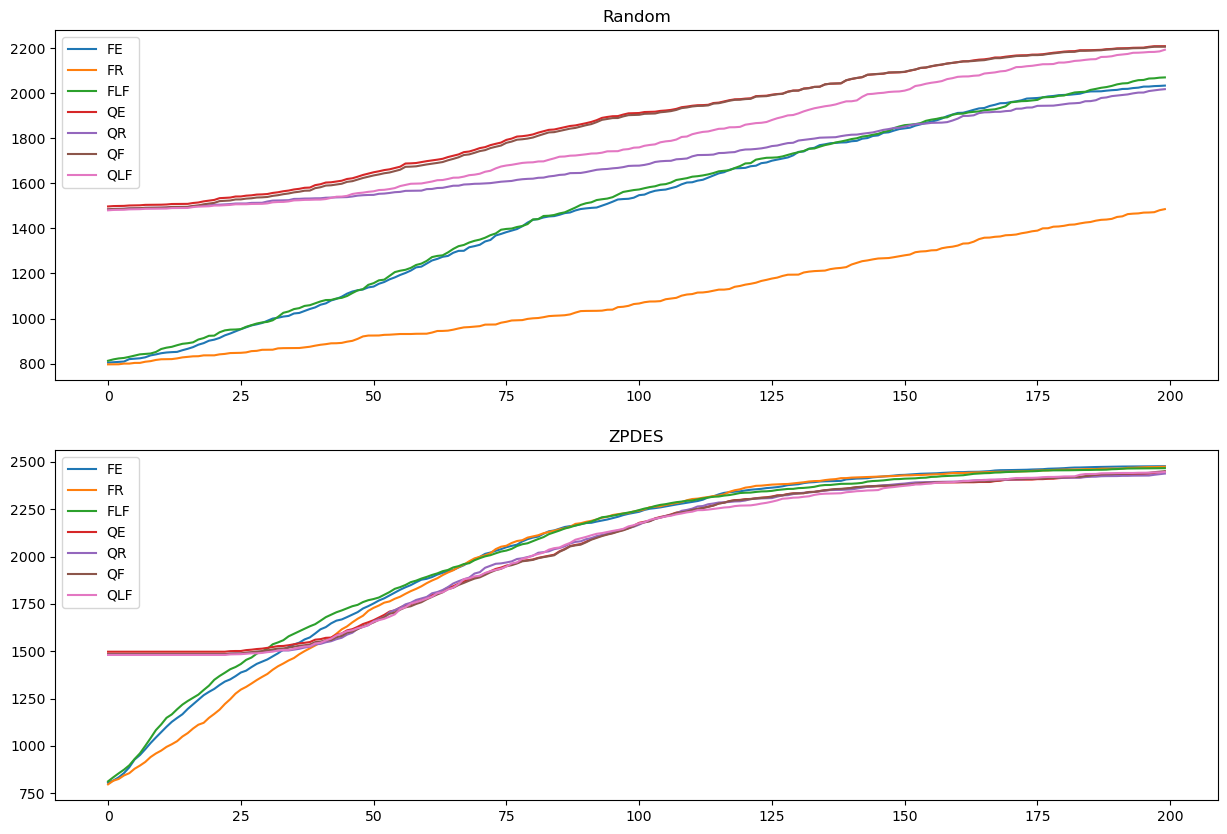

In [10]:
simulation(T=200, n_st=100, profile='mobility') # Deficit of mobility

100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


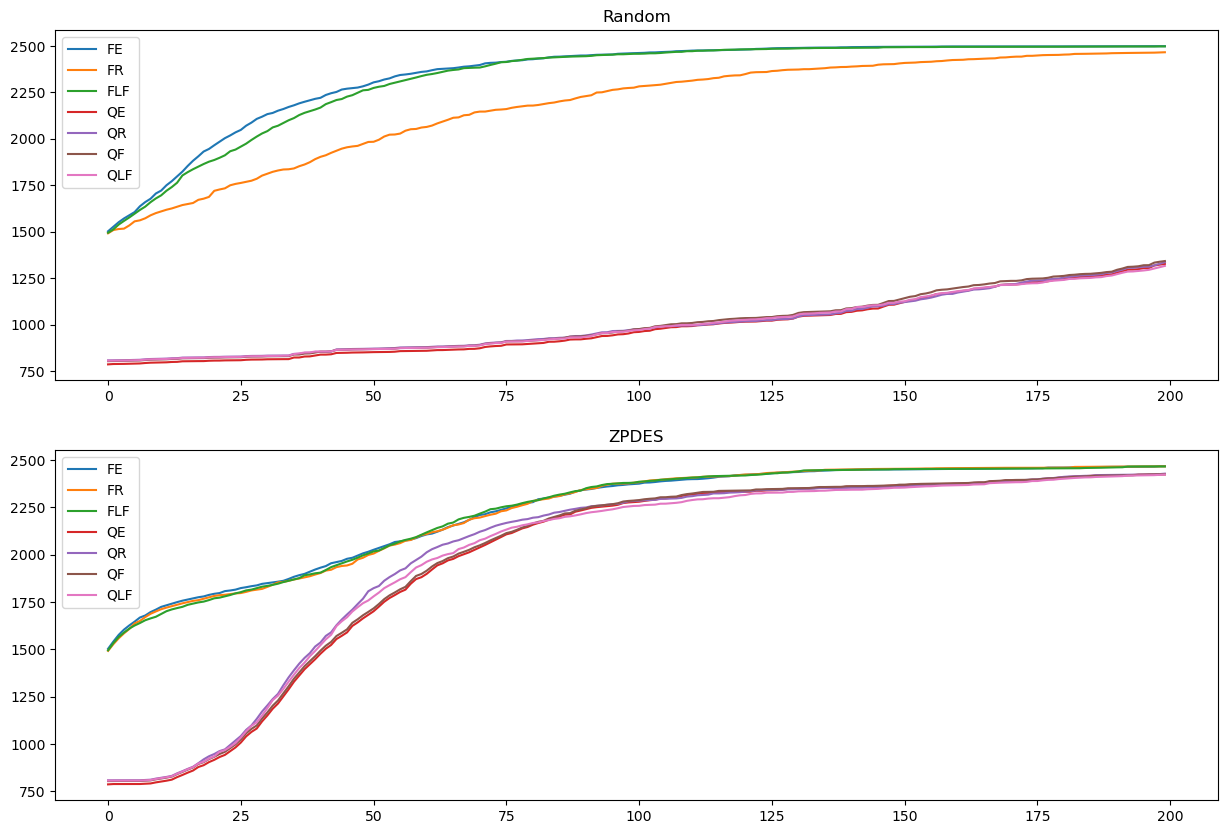

In [11]:
simulation(T=200, n_st=100, profile='stability') # Deficit of stability